## Importing Packages

In [1]:
"""
Importing (using/include) packages and files needed for the code to run

Topo.jl --- Topography Setup

Note: that we import pyplot last to avoid a name conflict with grid
"""

using SparseArrays
using LinearAlgebra
using IterativeSolvers
using WriteVTK
using Printf
using Statistics
using Dates
include("Grid.jl")
include("Markers.jl")
include("Stokes.jl")
include("Temperature.jl")
include("GridOperations.jl")
# Note: that we import pyplot last to avoid a name conflict with grid
using PyPlot
include("Visualization.jl")

plots (generic function with 1 method)

# Topography Setup

In [2]:
function initial_ice_depth(x::Float64,ice_thickness::Float64,wavelength::Float64,amplitude::Float64,initial_surface_depth::Float64)
    return ice_thickness + initial_surface_depth + amplitude*sin( 2*pi/wavelength*x )
end

function ice_viscosity(T::Float64)
    """
    Arguments:
    T::Float64 --- A temperature value in (Kelvin) of float64

    Returns:
    ice_vis -- The ice viscosity in (Pa*s) that is dependent on temperature argument value

    Info:
    The equation used is a Newtonian formulation for temperature-dependent ice viscosity from Nimmo(2004)
    """
    Q = 40000.0 # Activation Enegry (J/mol)
    R_cont = 8.314 # Gas Constant (J/mol*K)
    ice_vis = (1e15)*exp((Q*(273.0-T))/(R_cont*(273.0*T)))
    upperlimit = 1e25
    lowerlimit = 1e12
    if ice_vis < lowerlimit
        ice_vis = lowerlimit
    elseif ice_vis > upperlimit
        ice_vis = upperlimit
    else 
        ice_vis = ice_vis
    end 
    return ice_vis
end

ice_viscosity (generic function with 1 method)

# Material Setup

In [3]:
struct Materials
    """
    Building composite types with a list of fields (or attributes) which are names that will be used as variables to store data for
    objects of the new types.

    Fields:
    alpha::Vector{Float64} -- A vector(1-D Array) that holds values of Thermal expansion in (1/K)
    rho0::Vector{Float64} -- A vector (1-D Array) that holds values of  Density in (kg/m^3)
    Hr::Vector{Float64} -- A vector(1-D Array) that holds values of Radiogenic heat production in (W/m^3)
    Cp::Vector{Float64} -- A vector(1-D Array) that holds values of Heat capacity in (J/kg*K)
    kThermal::Vector{Float64} -- A vector(1-D Array) that holds values of Thermal conductivity in (W/m*K)
    eta::Vector{Float64} -- A vector(1-D Array) that holds values of Viscosity in (Pa*s = kg/m*s)

    Info:
    Each vector hold 3 elements which correspond to layer
    # 1 - subsurface global ocean
    # 2 - icy shell
    # 3 - sticky air
    """
    alpha::Vector{Float64} # Thermal expansion (1/K)
    rho0::Vector{Float64} # Density (kg/m^3)
    Hr::Vector{Float64} # Radiogenic heat production (W/m^3)
    Cp::Vector{Float64} # Heat capacity (J/kg*K)
    kThermal::Vector{Float64} # Thermal conductivity (W/m*K)
    eta::Vector{Float64} # Viscosity (Pa*s)
    function Materials()
        new([0.0,0.0,0.0],[1000.0,920.0,1.0],[0.0,0.0,0.0],[4180.0,2100.0,1.0e6],[0.5610,2.1,0.024],[1e12,1e15,1e17])
    end    
end

function update_marker_prop!(markers::Markers,materials::Materials)
    eta = markers.scalarFields["eta"]
    rho = markers.scalarFields["rho"]
    T = markers.scalarFields["T"]
    mmat = markers.integers[markers.integerFields["material"],:]
    for i in 1:markers.nmark
        markers.scalars[rho,i] = materials.rho0[mmat[i]]
        if mmat[i] == 2
            markers.scalars[eta,i] = ice_viscosity(markers.scalars[T,i])
        end
    end
end

function update_marker_temp!(markers::Markers,materials::Materials)
    T = markers.scalarFields["T"]
    mmat = markers.integers[markers.integerFields["material"],:]
    for i in 1:markers.nmark
        if mmat[i] == 1 
            markers.scalars[T,i] = 273.0
        elseif mmat[i] == 3 
            markers.scalars[T,i] = 100.0
        end 
    end 
end 

function initial_conditions!(markers::Markers,materials::Materials,options::Dict)
    material = markers.integerFields["material"]
    T = markers.scalarFields["T"]
    eta = markers.scalarFields["eta"]
    alpha = markers.scalarFields["alpha"]
    Cp = markers.scalarFields["Cp"]
    Hr = markers.scalarFields["Hr"]
    kThermal = markers.scalarFields["kThermal"]
    for i in 1:markers.nmark
        mx = markers.x[1,i]
        my = markers.x[2,i]
        hice = initial_ice_depth(mx,options["ice thickness"],options["wavelength"],options["amplitude"],options["surface depth"])
        hsurf = options["surface depth"]
        if my > hice
            # subsurface global ocean
            markers.integers[material,i] = 1
            markers.scalars[T,i] = 273.0
            markers.scalars[eta,i] = materials.eta[1]
            markers.scalars[alpha,i] = materials.alpha[1]        
            markers.scalars[Cp,i] = materials.Cp[1]
            markers.scalars[Hr,i] = materials.Hr[1] 
            markers.scalars[kThermal,i] = materials.kThermal[1]
        elseif my > hsurf
            # icy shell
            markers.integers[material,i] = 2
            markers.scalars[T,i] = 100.0+((273.0-100.0)/(hice-hsurf))*(my-hsurf)
            # markers.scalars[eta,i] = eta_i[i]
            markers.scalars[alpha,i] = materials.alpha[2]
            markers.scalars[Cp,i] = materials.Cp[2]
            markers.scalars[Hr,i] = materials.Hr[2]
            markers.scalars[kThermal,i] = materials.kThermal[2]
        else
            # sticky air
            markers.integers[material,i] = 3
            markers.scalars[T,i] = 100.0            
            markers.scalars[eta,i] = materials.eta[3]
            markers.scalars[alpha,i] = materials.alpha[3]  
            markers.scalars[Cp,i] = materials.Cp[3]
            markers.scalars[Hr,i] = materials.Hr[3]
            markers.scalars[kThermal,i] = materials.kThermal[3]
        end
    end 
    # end loop over markers
    update_marker_prop!(markers,materials)
end

function get_interface(grid::CartesianGrid,mat::Matrix{Float64},contour_value::Float64)
    # Finding interfaces 
    interface_position = zeros(Float64,grid.nx+1);
    for j in 1:grid.nx+1
        i = 1
        while i <= grid.ny
            if mat[i,j] == contour_value
                interface_position[j] = grid.yc[i]
                break
            elseif mat[i+1,j] < contour_value
                # interface is located within this cell.
                interface_position[j] = grid.yc[i] + (grid.yc[i+1]-grid.yc[i])/(mat[i+1,j]-mat[i,j])*(contour_value-mat[i,j])
                break
            end
            i = i+1
        end
    end
    return interface_position
end

get_interface (generic function with 1 method)

# Model Setup

In [4]:
function run(options::Dict)
    W = options["wavelength"]
    H = options["ice thickness"] + options["surface depth"] + options["amplitude"] + 1e4
    ny = 251
    nx = Int64(ceil(W/H*ny))
        
    gx = 0.0
    gy = 0.113 

    Tbctype = [-1,-1,1,1] #left, right, top, bottom
#     Tbctype = [1,-1,1,1]
    Tbcval = [0.0,0.0,100.0,273.0] #left, right, top, bottom
#     Tbcval = [273.0,0.0,100.0,273.0]
    bc = BoundaryConditions(0,0,0,0) # currently does nothing but is required argument to stokes solver.
    materials = Materials()

    markx = 6
    marky = 6
    seconds_in_year = 3.15e7
    plot_interval = 1e6*seconds_in_year # plot interval in seconds
    end_time = 3e7*seconds_in_year
    dtmax = plot_interval
    grid = CartesianGrid(W,H,nx,ny)
    println("Creating Markers...")
    @time markers = Markers(grid,["alpha","T","rho","eta","Cp","Hr","kThermal"],["material"] ; nmx=markx,nmy=marky,random=true)
    println("Initial condition...")
    @time initial_conditions!(markers, materials,options)

    local time_plot = []
    local max_topo = []
    local topography = []
    ### Setting up agruments for interface function ###
    # initial 
    i_mat, = marker_to_stag(markers,grid,markers.integers[[markers.integerFields["material"]],:],"center")
    i_air_ice_interface = get_interface(grid,i_mat,2.5)
    i_ocean_ice_interface = get_interface(grid,i_mat,1.5)

    ### Setting up agruments for termination criteria ###
    max_step::Int64=100
    max_time::Float64=-1.0
    max_time = max_time == -1.0 ? typemax(Float64) : max_time
    max_step = max_step == -1 ? typemax(Int64) : max_step

    time = 0.0
    iout= 0
    last_plot = 0.0
    dt = 1e10

    rho_c = nothing
    rho_vx = nothing 
    rho_vy = nothing 
    alpha = nothing 
    Hr = nothing 
    Cp_c = nothing 
    eta_s = nothing 
    eta_n = nothing 
    vxc = nothing 
    vyc = nothing 
    T = nothing 
    dTmax = nothing 
    dTemp = nothing 
    Tnew = nothing 
    Tlast = nothing 
    x_time = nothing
    kThermal = nothing
    ocean_ice_interface = nothing
    mat = nothing

    itime = 1
    output_dir = "test"

    terminate = false
    while !terminate
        # 0. update the markers properties  
        update_marker_prop!(markers,materials)
        update_marker_temp!(markers,materials)
        # 1. Transfer properties markers -> nodes
        # 1a. Basic Nodes
        eta_s_new, = marker_to_stag(markers,grid,["eta",],"basic")
        # 1b. Cell Centers
        rho_c_new,Cp_c_new,alpha_new,eta_n_new,Tlast_new,Hr_new,kThermal_new = marker_to_stag(markers,grid,["rho","Cp","alpha","eta","T","Hr","kThermal"],"center")
        # 1c. Vx and Vy nodes:
        rho_vx_new, = marker_to_stag(markers,grid,["rho",],"vx")
        rho_vy_new, = marker_to_stag(markers,grid,["rho",],"vy") 

        # deal with any NaN values from interpolation:
        if itime > 1
            if any(isnan.(eta_s_new))
                println("found nan values")
            end
            replace_nan!(eta_s,eta_s_new)
            replace_nan!(rho_c,rho_c_new)
            replace_nan!(Hr,Hr_new)
            replace_nan!(Cp_c,Cp_c_new)
            replace_nan!(alpha,alpha_new)
            replace_nan!(eta_n,eta_n_new)
            replace_nan!(Tlast,Tlast_new)
            replace_nan!(rho_vx,rho_vx_new)
            replace_nan!(rho_vy,rho_vy_new)
            replace_nan!(kThermal,kThermal_new)
        end
        # Copy field data 
        kThermal = copy(kThermal_new)
        rho_vx = copy(rho_vx_new)
        rho_vy = copy(rho_vy_new)
        rho_c = copy(rho_c_new)
        Hr = copy(Hr_new)
        Cp_c = copy(Cp_c_new)
        alpha = copy(alpha_new)
        eta_s = copy(eta_s_new)
        eta_n = copy(eta_n_new)
        Tlast = copy(Tlast_new)

        if itime == 1 
#             println(Tbctype,Tbcval)
            ghost_temperature_center(grid,Tlast,Tbctype,Tbcval)
            cell_center_to_markers!(markers,grid,Tlast,markers.scalars[[markers.scalarFields["T"],],:])
        else
            ghost_temperature_center(grid,Tlast,Tbctype,Tbcval)
        end

        # 2. Assemble and solve the stokes equations
        L,R = form_stokes(grid,eta_s,eta_n,rho_vx,rho_vy,bc,gx,gy;dt=dt)
        stokes_solution = L\R
        vx,vy,P = unpack(stokes_solution,grid;ghost=true)

        # Get the velocity at the cell centers:
        vxc,vyc = velocity_to_centers(grid,vx,vy)
        adiabatic_heating = compute_adiabatic_heating(grid,rho_c,Tlast,alpha,gx,gy,vxc,vyc)*0.0
        shear_heating = compute_shear_heating(grid,vx,vy,eta_n,eta_s)*0.0
        H = (adiabatic_heating .+ shear_heating .+ Hr).*0.0

        # 3. Compute the advection timestep
        if itime > 1
            this_dtmax = min(1.2*dt,dtmax)
        else
            this_dtmax = dtmax
        end
        dt = compute_timestep(grid,vxc,vyc;dtmax=this_dtmax,cfl=0.25)
        diffusion_timestep = (grid.x[2]-grid.x[1])^2 / 1e-6
        if dt > diffusion_timestep
            dt = diffusion_timestep
        end

        dTmax = Inf
        dTemp = nothing
        Tnew = nothing
        titer = 1
        for titer=1:2
            # assemble and solve the energy equation
            println("Trying with timestep ",dt/seconds_in_year/1e3," kyr")
            L,R = assemble_energy_equation_center(grid,rho_c,Cp_c,kThermal,H,Tlast,dt,Tbctype,Tbcval)
            Tnew = L\R;
            Tnew = reshape(Tnew,grid.ny,grid.nx);
            Tnew = ghost_temperature_center(grid,Tnew,Tbctype,Tbcval)
            T = copy(Tnew)

            dTemp = Tnew-Tlast
            # compute the maximum temperature change
            dTmax = maximum(abs.(dTemp[2:end-1,2:end-1]));
            println("dTmax=",dTmax," dt=",dt/seconds_in_year/1e3," kyr")
            dt = min(dt,dTmax < 10.0 ? dt : dt*10.0/dTmax)
            if dTmax < 10.0
                break
            end
        end

        dT_subgrid_node = subgrid_temperature_relaxation_center!(markers,grid,Tlast,Cp_c[1,1],kThermal[1,1],dt)
        dT_remaining = dTemp - dT_subgrid_node

        cell_center_change_to_markers!(markers,grid,dT_remaining,"T")

        # Checking Termination Criteria, time is in Myr
        if time >= max_time || itime >= max_step
            terminate = true
        end    

#         if time == 0.0 || mod(itime,100) == 0 || true
#             last_plot = time 
#             # Gird output
#             name1 = @sprintf("%s/viz.%04d.vtr",output_dir,iout)
#             println("Writing visualization file = ",name1)
#             vn = velocity_to_basic_nodes(grid,vxc,vyc)
#             visualization(grid,rho_c,eta_s,vn,P,Tnew[2:end-1,2:end-1],time/seconds_in_year;filename=name1)
#             # Markers output
#             name2 = @sprintf("%s/markers.%04d.vtp",output_dir,iout)
#             println("Writing visualization file = ",name2)
#             visualization(markers,time/seconds_in_year;filename=name2)
#             iout += 1
#         end

        # println("Min/Max velocity: ",minimum(vyc)," ",maximum(vyc))            
        # Moving the markers and advancing to the next timestep
        move_markers_rk4!(markers,grid,vx,vy,dt,continuity_weight=1/3)
        time += dt
        itime += 1
        println("Finished Step ",itime," time=",time/seconds_in_year/1e3," kyr")
        mat, = marker_to_stag(markers,grid,markers.integers[[markers.integerFields["material"]],:],"center")
        ocean_ice_interface = get_interface(grid,mat,1.5)
        air_ice_interface = get_interface(grid,mat,2.5)
        append!(time_plot,time)
#         append!(max_topo,maximum(ocean_ice_interface.-(options["ice thickness"] + options["surface depth"])))
        append!(topography,[ocean_ice_interface])
    end
    return grid,i_mat,mat,time_plot,topography,max_step
end

run (generic function with 1 method)

In [5]:
include("Topo.jl")
# include("FittingData.jl")
function model_run()
    local t_halfspace = []
    local t_viscous = []
    local t_thickening = []
    local lambda = []
    local hice = []
    for i in range(start = 1, stop = 50, length = 4)
        for j in range(start = 1, stop = 50, length = 4)
            if i > j
                options = Dict()
                options["wavelength"] = i*1e3
                options["ice thickness"] = j*1e3
                options["surface depth"] = 0.50*options["ice thickness"]
                options["amplitude"] = 0.10*options["ice thickness"]
                
                println("Using Wavelength: ",options["wavelength"]/1e3,"(km)")
                println("Using Ice Shell Thickness: ",options["ice thickness"]/1e3,"(km)")

                grid,i_mat,mat,times,topography,max_step = run(options)

                air_ice_interface = get_interface(grid,mat,2.5)
                ocean_ice_interface = get_interface(grid,mat,1.5)
                i_air_ice_interface = get_interface(grid,i_mat,2.5)
                i_ocean_ice_interface = get_interface(grid,i_mat,1.5)

                ths = get_time_viscous(options["wavelength"])
                tvis = get_numerical_time_viscous(i_air_ice_interface,air_ice_interface,i_ocean_ice_interface,ocean_ice_interface,last(times))
                ttic = get_thickening_time(options["ice thickness"])

                append!(t_halfspace,ths)
                append!(t_viscous,tvis)
                append!(t_thickening,ttic)
                append!(lambda,options["wavelength"])
                append!(hice,options["ice thickness"])
            end
        end
    end
    return lambda,hice,t_viscous,t_thickening,t_halfspace
end

model_run (generic function with 1 method)

In [6]:
modelrun = model_run()

Using Wavelength: 17.333333333333332(km)
Using Ice Shell Thickness: 1.0(km)
Creating Markers...
  0.141543 seconds (19 allocations: 347.616 MiB, 35.50% gc time)
Initial condition...
  2.064337 seconds (16.87 M allocations: 266.542 MiB, 1.62% gc time, 3.15% compilation time)
Trying with timestep 0.06782520086223788 kyr
dTmax=2.863805847641572 dt=0.06782520086223788 kyr
Finished Step 2 time=0.06782520086223788 kyr
Trying with timestep 0.06782520086223788 kyr
dTmax=2.7253087361708026 dt=0.06782520086223788 kyr
Finished Step 3 time=0.13565040172447576 kyr
Trying with timestep 0.06782520086223788 kyr
dTmax=2.72790173026857 dt=0.06782520086223788 kyr
Finished Step 4 time=0.20347560258671366 kyr
Trying with timestep 0.06782520086223788 kyr
dTmax=2.7801046307474166 dt=0.06782520086223788 kyr
Finished Step 5 time=0.2713008034489515 kyr
Trying with timestep 0.06782520086223788 kyr
dTmax=2.820782331809937 dt=0.06782520086223788 kyr
Finished Step 6 time=0.33912600431118944 kyr
Trying with timestep

(Any[17333.333333333332, 33666.666666666664, 33666.666666666664, 50000.0, 50000.0, 50000.0], Any[1000.0, 1000.0, 17333.333333333332, 1000.0, 17333.333333333332, 33666.666666666664], Any[1.5964455763860147e7, 2.257433614510853e7, 72367.6522573341, 5.565690164992496e7, 106784.70017571773, 25742.696875557624], Any[27859.10300361167, 27859.10300361167, 8.370112724640661e6, 27859.10300361167, 8.370112724640661e6, 3.1576745526649177e7], Any[2545.9436720718613, 1310.7828806706611, 1310.7828806706611, 882.5938063182451, 882.5938063182451, 882.5938063182451])

In [7]:
wavelength = modelrun[1][:]
ice_shell = modelrun[2][:]
timevis = modelrun[3][:]
timethick =modelrun[4][:]
timehalfspace = modelrun[5][:]

6-element Vector{Any}:
 2545.9436720718613
 1310.7828806706611
 1310.7828806706611
  882.5938063182451
  882.5938063182451
  882.5938063182451

In [8]:
dataset = []

Any[]

In [9]:
push!(dataset,[wavelength,ice_shell,timevis,timethick,timehalfspace])

1-element Vector{Any}:
 Vector{Any}[[17333.333333333332, 33666.666666666664, 33666.666666666664, 50000.0, 50000.0, 50000.0], [1000.0, 1000.0, 17333.333333333332, 1000.0, 17333.333333333332, 33666.666666666664], [1.5964455763860147e7, 2.257433614510853e7, 72367.6522573341, 5.565690164992496e7, 106784.70017571773, 25742.696875557624], [27859.10300361167, 27859.10300361167, 8.370112724640661e6, 27859.10300361167, 8.370112724640661e6, 3.1576745526649177e7], [2545.9436720718613, 1310.7828806706611, 1310.7828806706611, 882.5938063182451, 882.5938063182451, 882.5938063182451]]

In [10]:
dataset = vcat(map(x->x',dataset)...)

1×5 Matrix{Adjoint{Any, Vector{Any}}}:
 [17333.3 33666.7 … 50000.0 50000.0]  …  [2545.94 1310.78 … 882.594 882.594]

In [11]:
dataset = hcat(map(x->x',dataset)...)

6×5 Matrix{Float64}:
 17333.3   1000.0      1.59645e7  27859.1        2545.94
 33666.7   1000.0      2.25743e7  27859.1        1310.78
 33666.7  17333.3  72367.7            8.37011e6  1310.78
 50000.0   1000.0      5.56569e7  27859.1         882.594
 50000.0  17333.3      1.06785e5      8.37011e6   882.594
 50000.0  33666.7  25742.7            3.15767e7   882.594

In [12]:
using DataFrames
df = DataFrame(lambda = dataset[:,1], hice = dataset[:,2], numerical_time = dataset[:,3], thickening_time = dataset[:,4], halfspace_time = dataset[:,5])

Row,lambda,hice,numerical_time,thickening_time,halfspace_time
,Float64,Float64,Float64,Float64,Float64
1,17333.3,1000.0,1.59645e7,27859.1,2545.94
2,33666.7,1000.0,2.25743e7,27859.1,1310.78
3,33666.7,17333.3,72367.7,8.37011e6,1310.78
4,50000.0,1000.0,5.56569e7,27859.1,882.594
5,50000.0,17333.3,1.06785e5,8.37011e6,882.594
6,50000.0,33666.7,25742.7,3.15767e7,882.594


In [13]:
h5open("modelrun.hdf5", "w") do file
    # Creating Groups for Data
    g = create_group(file, "Model Run")
    # Storing Data Inside the Group
    g["Wavelength"] = df.lambda
    g["Relaxation Time(Model)"] = df.numerical_time 
    g["Thickening Time"] = df.thickening_time
    g["Relaxation Time(Halfspace)"] = df.halfspace_time  
    g["Ice Shell Thickness"] = df.hice
    # Apply an Attribute to Groups
    attrs(g)["Description"] = "This group contains only a 4 dataset"
end

LoadError: UndefVarError: `h5open` not defined

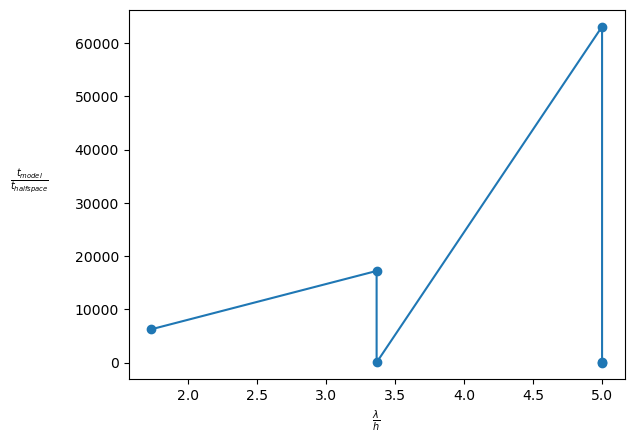

In [18]:
figure()
plot(df.lambda./1e4,df.numerical_time./df.halfspace_time,"-o")
gca().set_xlabel(L"\frac{\lambda}{h}")
gca().set_ylabel(L"\frac{t_{model}}{t_{halfspace}}",rotation=0)
gca().yaxis.set_label_coords(-0.2,0.5)
show()

In [19]:
using HDF5

[ Info: Precompiling HDF5 [f67ccb44-e63f-5c2f-98bd-6dc0ccc4ba2f]
ERROR: LoadError: InitError: could not load library "/home/caguirre/.julia/artifacts/4cca3b6cb9a75d3ade7efe6915abfcd7dae86644/lib/libhdf5.so"
libcrypto.so.3: cannot open shared object file: No such file or directory
Stacktrace:
  [1] dlopen(s::String, flags::UInt32; throw_error::Bool)
    @ Base.Libc.Libdl ./libdl.jl:117
  [2] dlopen(s::String, flags::UInt32)
    @ Base.Libc.Libdl ./libdl.jl:116
  [3] macro expansion
    @ ~/.julia/packages/JLLWrappers/nEaFF/src/products/library_generators.jl:63 [inlined]
  [4] __init__()
    @ HDF5_jll ~/.julia/packages/HDF5_jll/rRmEU/src/wrappers/x86_64-linux-gnu-libgfortran5-cxx11-mpi+mpich.jl:15
  [5] register_restored_modules(sv::Core.SimpleVector, pkg::Base.PkgId, path::String)
    @ Base ./loading.jl:1115
  [6] _include_from_serialized(pkg::Base.PkgId, path::String, ocachepath::String, depmods::Vector{Any})
    @ Base ./loading.jl:1061
  [7] _require_search_from_serialized(pkg::Bas

LoadError: Failed to precompile HDF5 [f67ccb44-e63f-5c2f-98bd-6dc0ccc4ba2f] to "/home/caguirre/.julia/compiled/v1.9/HDF5/jl_T7hXlB".